## Imports

In [1]:
import argparse
import os
import time
import sys
import random
import gc
import json
import pickle
from collections import Counter, namedtuple
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.api as sm
from scipy.linalg import eigh

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_validate,
    TimeSeriesSplit,
    KFold,
    StratifiedKFold,
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (
    make_scorer,
    confusion_matrix,
    ConfusionMatrixDisplay,
    balanced_accuracy_score,
    precision_recall_fscore_support as score,
    f1_score,
    r2_score,
    mean_absolute_error as mae,
    mean_squared_error as mse
)
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.cross_decomposition import CCA
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

from IPython.display import display
from tqdm.notebook import tqdm

manualSeed = 111
SEED = manualSeed
FREQ = 250
random.seed(manualSeed)

DATA_DIR = '../experiment-results/'
FIGURES_DIR = '../figures/'

## Vizualization helpers

In [41]:
sns.set(context="paper", style="whitegrid", font_scale=1.2)

marker_cycle = ['o', 's', 'D', '^', 'v', 'P', '*', 'X', 'h', '>']

plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 12
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 24
plt.rcParams["legend.fontsize"] = 24
plt.rcParams["axes.titlesize"] = 30
plt.rcParams["axes.labelsize"] = 24
plt.rcParams["figure.figsize"] = (12, 7)


def pivot_heat(df, value="max_F1w"):
    """Wide table indexed by d_c, d_r for seaborn.heatmap."""
    return df.pivot(index="d_c", columns="d_hid", values=value).sort_index(ascending=True)


def save_fig(name, dpi=300):
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f"{name}.pdf"), dpi=dpi, bbox_inches="tight")


def plot_heatmap(df, title, value, cmap="cubehelix_r", fmt=".3f"):
    fig, ax = plt.subplots(figsize=(14, 10))
    sns.heatmap(pivot_heat(df, value), annot=True, fmt=fmt,
                cmap=cmap, cbar_kws={"label": "F1-macro"}, ax=ax)
    ax.set_title(title, fontsize=34)
    ax.set_xlabel(r"$d_{hid}$", fontsize=28)
    ax.set_ylabel(r"$d_c$", fontsize=28)
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f"{title.lower().replace(' ', '-').replace('.', '-')}.pdf"))


def diff_heat(df_high, df_low, label_high, label_low, value="max_F1w", figsize=(10, 8), cmap="coolwarm_r", fmt=".2f", annot=True):
    A = pivot_heat(df_high, value)
    B = pivot_heat(df_low, value)
    diff = (A - B).loc[A.index.intersection(B.index),
                       A.columns.intersection(B.columns)]

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(diff, center=0, cmap=cmap,
                annot=annot, fmt=fmt, ax=ax)
    ax.set_title(f"Δ F1 ({label_high} – {label_low})", fontsize=34)
    ax.set_xlabel(r"$d_{hid}$", fontsize=28)
    ax.set_ylabel(r"$d_c$", fontsize=28)
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'heatmap-delta-{value}-{label_high}-{label_low}.pdf'))
    plt.show()

## Tennis dataset

### Read and process data

Constants

In [3]:
SUBDIR = 'human-player'
F1_MACRO_COLS = ['LogReg_F1m', 'kNN_F1m', 'CatBoost_F1m']
F1_WEIGHTED_COLS = ['LogReg_F1w', 'kNN_F1w', 'CatBoost_F1w']
SPACES = ['Original', 'Riemannian', 'Trajectory']

Read datasets

In [4]:
riemannian_tr_te = pd.read_csv(os.path.join(DATA_DIR, SUBDIR, 'baseline_tr_te.csv'))
riemannian_other = pd.read_csv(os.path.join(DATA_DIR, SUBDIR, 'baseline_other.csv'))
riemannian_casca = pd.read_csv(os.path.join(DATA_DIR, SUBDIR, 'baseline_casca.csv'))

original_tr_te = pd.read_csv(os.path.join(DATA_DIR, SUBDIR, 'original_tr_te.csv'))
original_other = pd.read_csv(os.path.join(DATA_DIR, SUBDIR, 'original_other.csv'))
original_casca = pd.read_csv(os.path.join(DATA_DIR, SUBDIR, 'original_casca.csv'))

trajectory_tr_te = pd.read_csv(os.path.join(DATA_DIR, SUBDIR, 'trajectory_tr_te.csv'))
trajectory_other = pd.read_csv(os.path.join(DATA_DIR, SUBDIR, 'trajectory_other.csv'))
trajectory_casca = pd.read_csv(os.path.join(DATA_DIR, SUBDIR, 'trajectory_casca.csv'))

Drop incorrect measurements

In [5]:
original_casca.drop(index=original_casca.query("d_c == 30 & d_hid == 30").index, inplace=True)
riemannian_casca.drop(index=riemannian_casca.query("d_c == 30 & d_hid == 30").index, inplace=True)
trajectory_casca.drop(index=trajectory_casca.query("d_c == 30 & d_hid == 30").index, inplace=True)

Calculate best f1-macro and f1-weighted score

In [6]:
original_casca['max_F1w'] = original_casca[F1_WEIGHTED_COLS].max(axis=1)
original_casca['max_F1m'] = original_casca[F1_MACRO_COLS].max(axis=1)
original_other['max_F1w'] = original_other[F1_WEIGHTED_COLS].max(axis=1)
original_other['max_F1m'] = original_other[F1_MACRO_COLS].max(axis=1)

riemannian_casca['max_F1w'] = riemannian_casca[F1_WEIGHTED_COLS].max(axis=1)
riemannian_casca['max_F1m'] = riemannian_casca[F1_MACRO_COLS].max(axis=1)
riemannian_other['max_F1w'] = riemannian_other[F1_WEIGHTED_COLS].max(axis=1)
riemannian_other['max_F1m'] = riemannian_other[F1_MACRO_COLS].max(axis=1)

trajectory_casca['max_F1w'] = trajectory_casca[F1_WEIGHTED_COLS].max(axis=1)
trajectory_casca['max_F1m'] = trajectory_casca[F1_MACRO_COLS].max(axis=1)
trajectory_other['max_F1w'] = trajectory_other[F1_WEIGHTED_COLS].max(axis=1)
trajectory_other['max_F1m'] = trajectory_other[F1_MACRO_COLS].max(axis=1)

Separate PureCCA and PurePCA for comparison

In [7]:
col_order = original_casca.columns

original_cca = original_other\
    .query("din_red_model == 'PureCCA'")\
    .assign(d_c=lambda x: x.d_hid)\
    .drop(columns=["din_red_model"])\
    [col_order]
original_pca = original_other\
    .query("din_red_model == 'PurePCA'")\
    .assign(d_c=0)\
    .drop(columns=["din_red_model"])\
    [col_order]

riemannian_cca = riemannian_other\
    .query("din_red_model == 'PureCCA'")\
    .assign(d_c=lambda x: x.d_hid)\
    .drop(columns=["din_red_model"])\
    [col_order]
riemannian_pca = riemannian_other\
    .query("din_red_model == 'PurePCA'")\
    .assign(d_c=0)\
    .drop(columns=["din_red_model"])\
    [col_order]

trajectory_cca = trajectory_other\
    .query("din_red_model == 'PureCCA'")\
    .assign(d_c=lambda x: x.d_hid)\
    .drop(columns=["din_red_model"])\
    [col_order]
trajectory_pca = trajectory_other\
    .query("din_red_model == 'PurePCA'")\
    .assign(d_c=0)\
    .drop(columns=["din_red_model"])\
    [col_order]

### CaSCA vs baseline

Collect data

In [8]:
dfs = [original_tr_te, riemannian_tr_te, trajectory_tr_te]
cascas = [original_casca, riemannian_casca, trajectory_casca]
# collect the best rows for macro‐optimal and weighted‐optimal models in each space
records = []
for space, df, casca in zip(SPACES, dfs, cascas):
    # pick the two rows
    macro_base = df.f1_macro.max()
    weighted_base = df.f1_weighted.max()
    records.append({
        'space': space,
        'selection': 'No dim.red.',
        'f1_macro': macro_base,
        'f1_weighted': weighted_base
    })

    macro_causal_dim_red = casca.max_F1m.max()
    weighted_causal_dim_red = casca.max_F1w.max()

    records.append({
        'space': space,
        'selection': 'With dim.red.',
        'f1_macro': macro_causal_dim_red,
        'f1_weighted': weighted_causal_dim_red
    })

best_df = pd.DataFrame(records)

Plot data

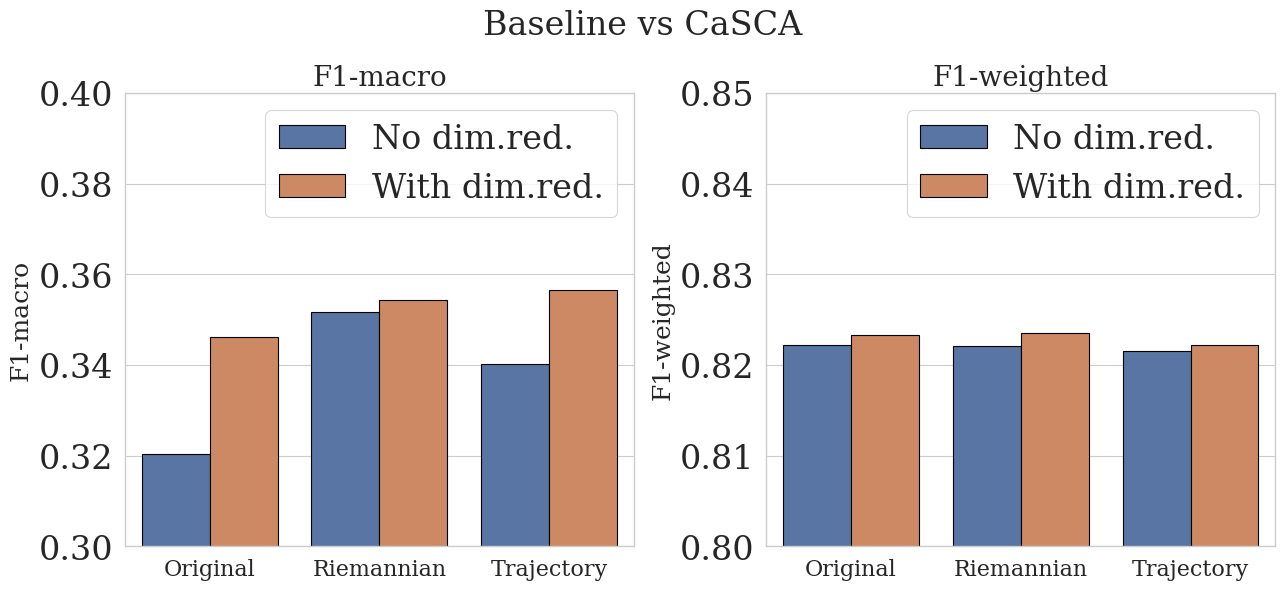

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

# F1-macro subplot
sns.barplot(
    data=best_df,
    x="space",
    y="f1_macro",
    hue="selection",
    # palette="Set2",
    edgecolor="black",
    ax=ax1
)
ax1.set_title("F1-macro", fontsize=20)
ax1.set_ylabel("F1-macro", fontsize=18)
ax1.set_xlabel("")
ax1.set_ylim(0.30, 0.40)
ax1.legend()

# F1-weighted subplot
sns.barplot(
    data=best_df,
    x="space",
    y="f1_weighted",
    hue="selection",
    # palette="Set2",
    edgecolor="black",
    ax=ax2
)
ax2.set_title("F1-weighted", fontsize=20)
ax2.set_ylabel("F1-weighted", fontsize=18)
ax2.set_xlabel("")
ax2.set_ylim(0.8, 0.85)
ax2.legend()

fig.suptitle("Baseline vs CaSCA", fontsize=24)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'baseline-vs-casca.pdf'))
plt.show()

### CaSCA in different spaces

Calculate best model scores for each space

In [10]:
def best_score(df, group=["space"]):
    return (df.groupby(group)[["max_F1w", "max_F1m"]]
              .max()
              .reset_index()
              .rename(columns={"max_F1m": "best_f1_macro", "max_F1w": "best_f1_weighted"}))

best = pd.concat([
    best_score(original_casca.assign(space="Original")),
    best_score(riemannian_casca.assign(space="Riemannian")),
    best_score(trajectory_casca.assign(space="Trajectory")),
])

Vizualize it

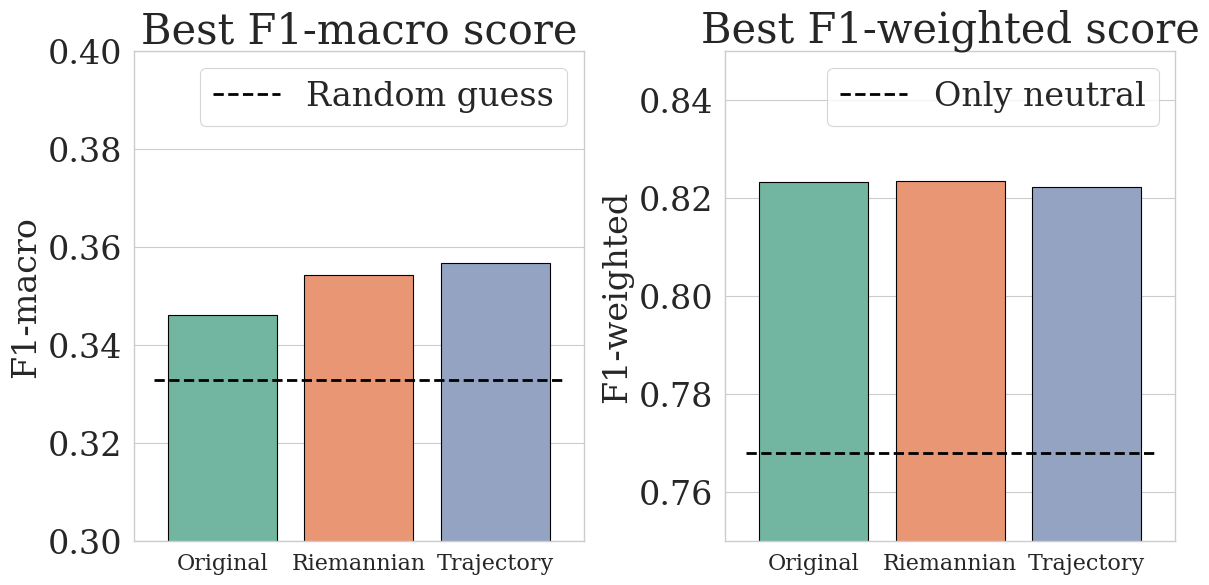

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# — F1-macro subplot —
sns.barplot(
    data=best,
    x="space", 
    y="best_f1_macro", 
    palette="Set2", 
    hue="space", 
    ax=ax1, 
    edgecolor="black",
    legend=False
)
ax1.hlines(
    y=0.333, 
    xmin=-0.5, 
    xmax=2.5,
    linestyles="--",
    color="black", 
    label="Random guess"
)
ax1.set_title("Best F1-macro score")
ax1.set_ylabel("F1-macro")
ax1.set_xlabel("")
ax1.set_ylim(0.3, 0.4)
ax1.legend()

# — F1-weighted subplot —
sns.barplot(
    data=best,
    x="space", 
    y="best_f1_weighted", 
    palette="Set2", 
    hue="space",
    ax=ax2, 
    edgecolor="black",
    legend=False
)
ax2.hlines(
    y=0.768, 
    xmin=-0.5, 
    xmax=2.5,
    linestyles="--",
    color="black", 
    label="Only neutral"
)
ax2.set_title("Best F1-weighted score")
ax2.set_ylabel("F1-weighted")
ax2.set_xlabel("")
ax2.set_ylim(0.75, 0.85)
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'casca-spaces-baseline.pdf'))
plt.show()

Calcualte average model quality for each model x space

In [12]:
avg_quality_model_x_space_df = pd.concat(
    (
        original_casca.iloc[..., 6:-2].agg(['mean', 'std']).T,
        riemannian_casca.iloc[..., 6:-2].agg(['mean', 'std']).T,
        trajectory_casca.iloc[..., 6:-2].agg(['mean', 'std']).T
    ),
    axis=1,
    keys=SPACES
)
avg_quality_model_x_space_df

Original           Riemannian           Trajectory          
                  mean       std       mean       std       mean       std
LogReg_F1w    0.624452  0.011392   0.644962  0.023723   0.656844  0.020384
LogReg_F1m    0.309869  0.005179   0.327117  0.011071   0.337004  0.011697
kNN_F1w       0.816139  0.003046   0.808083  0.005006   0.813814  0.001794
kNN_F1m       0.331122  0.004894   0.331342  0.009652   0.333559  0.004704
CatBoost_F1w  0.821444  0.000172   0.822286  0.000631   0.821197  0.000410
CatBoost_F1m  0.311767  0.000408   0.317794  0.002685   0.313340  0.001693

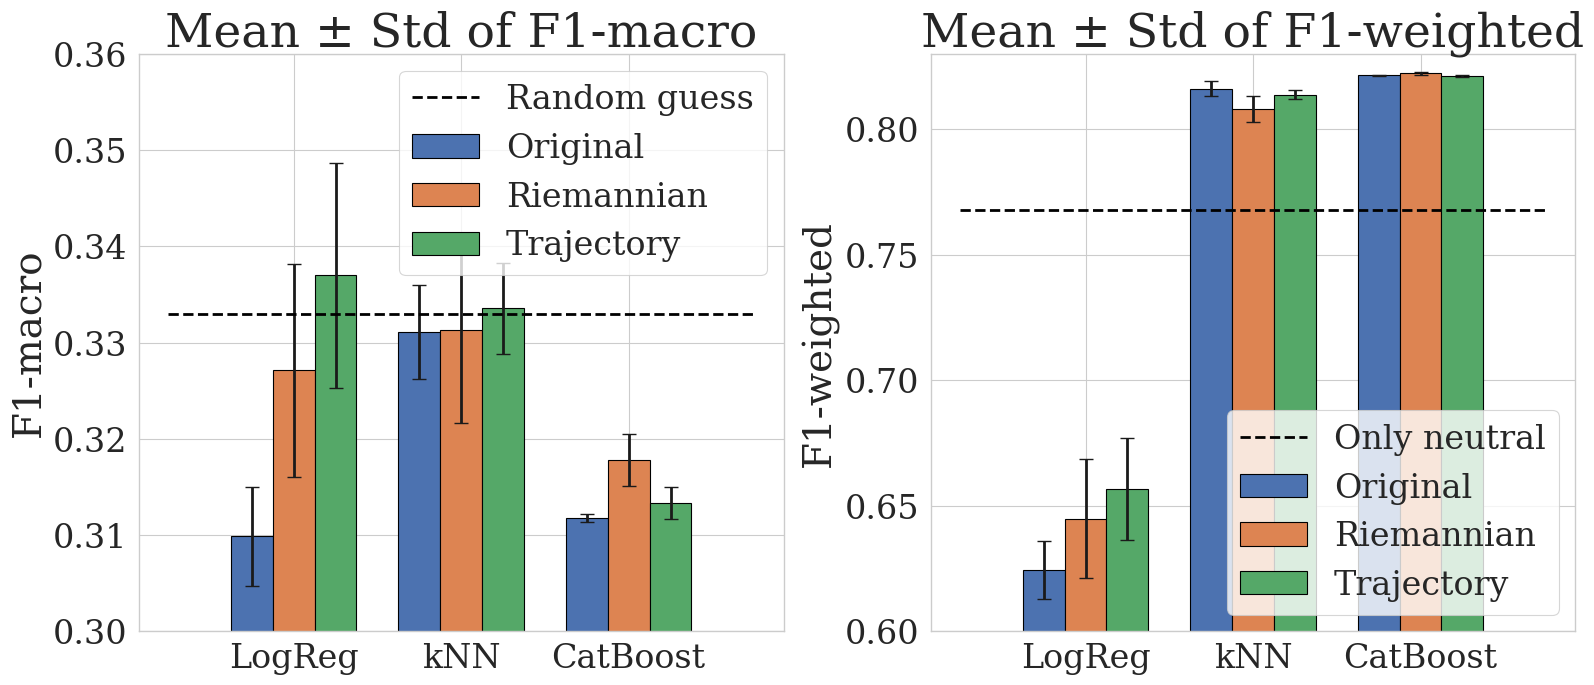

In [15]:
width = 0.25

macro_df = avg_quality_model_x_space_df.loc[
    avg_quality_model_x_space_df.index.str.endswith("F1m")
]
# extract means and stds: DataFrame of shape (3 models × 3 spaces)
macro_means = macro_df.xs("mean", axis=1, level=1)
macro_stds  = macro_df.xs("std",  axis=1, level=1)
# simplify model names: ['LogReg','kNN','CatBoost']
models_macro = macro_df.index.str.replace("_F1m", "")

# --- Prepare data for F1-weighted ---
weighted_df = avg_quality_model_x_space_df.loc[
    avg_quality_model_x_space_df.index.str.endswith("F1w")
]
weighted_means = weighted_df.xs("mean", axis=1, level=1)
weighted_stds  = weighted_df.xs("std",  axis=1, level=1)
models_weighted = weighted_df.index.str.replace("_F1w", "")

# x locations
x_macro = np.arange(len(models_macro))
x_weighted = np.arange(len(models_weighted))

# create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# --- Plot F1-macro ---
for i, space in enumerate(SPACES):
    ax1.bar(
        x_macro + (i - 1) * width,
        macro_means[space],
        width,
        yerr=macro_stds[space],
        capsize=5,
        label=space,
        edgecolor="black",
    )
ax1.hlines(0.333, x_macro[0] - 3*width, x_macro[-1] + 3*width, colors="black",
           linestyles="--", label="Random guess")
ax1.set_xticks(x_macro)
ax1.set_xticklabels(models_macro, fontsize=24)
ax1.set_ylim(0.3, 0.36)
ax1.set_title("Mean ± Std of F1-macro", fontsize=34)
ax1.set_ylabel("F1-macro", fontsize=28)
ax1.legend()

# --- Plot F1-weighted ---
for i, space in enumerate(SPACES):
    ax2.bar(
        x_weighted + (i - 1) * width,
        weighted_means[space],
        width,
        yerr=weighted_stds[space],
        capsize=5,
        label=space,
        edgecolor="black",
    )
ax2.hlines(0.768, x_weighted[0] - 3*width, x_weighted[-1] + 3*width,
           colors="black", linestyles="--", label="Only neutral")
ax2.set_xticks(x_weighted)
ax2.set_xticklabels(models_weighted, fontsize=24)
ax2.set_ylim(0.6, 0.83)
ax2.set_title("Mean ± Std of F1-weighted", fontsize=34)
ax2.set_ylabel("F1-weighted", fontsize=28)
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, 'casca-spaces-by-models.pdf'))

plt.show()

Heatmap of quality differences

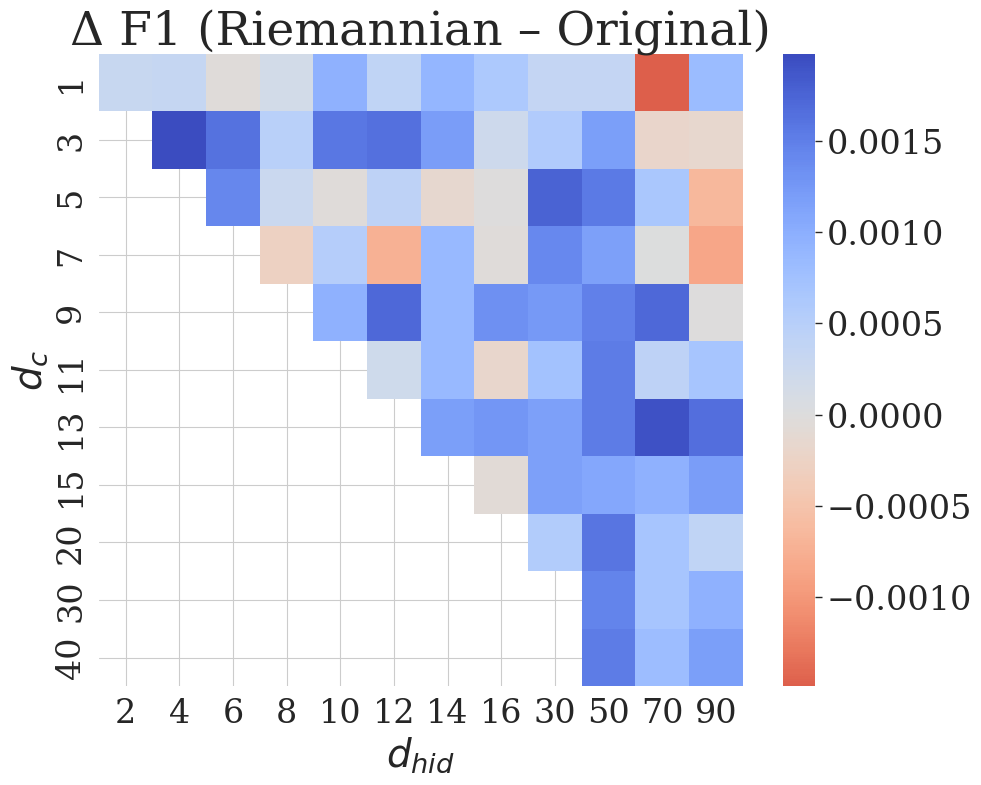

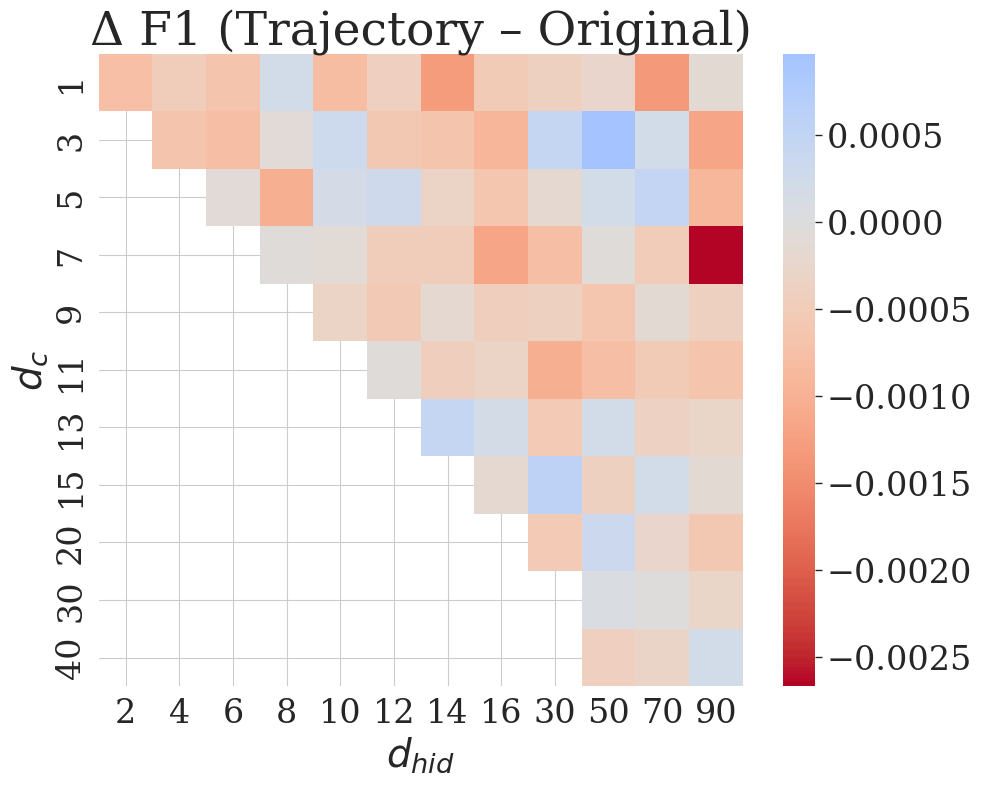

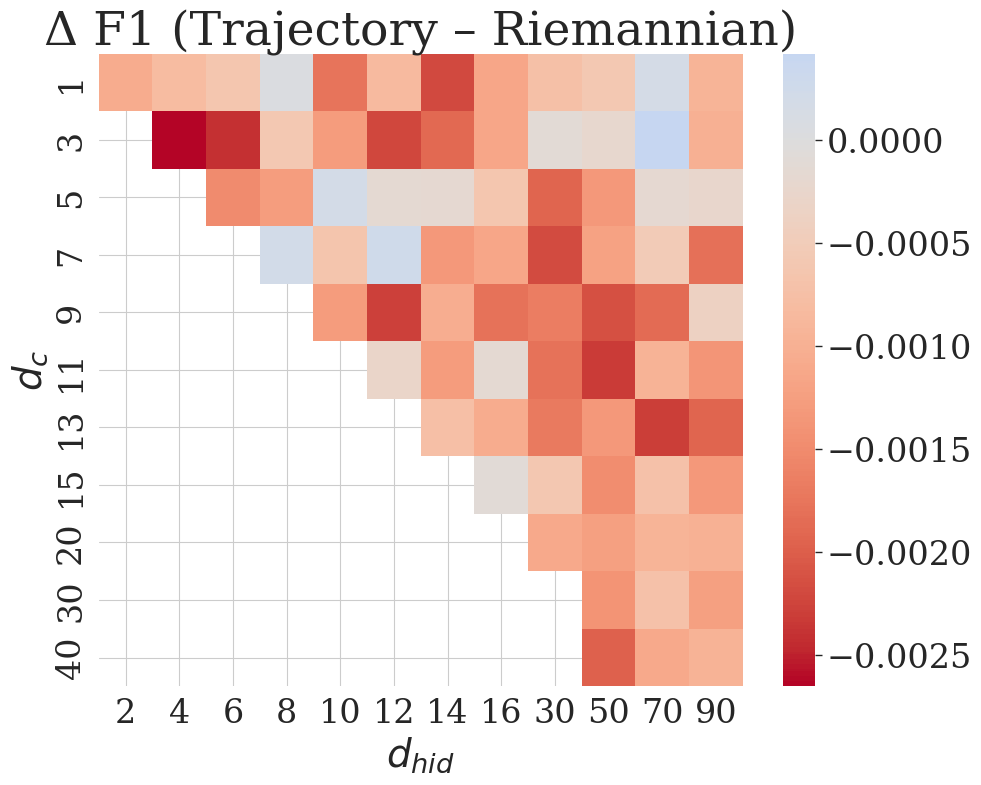

In [42]:
diff_heat(riemannian_casca, original_casca, "Riemannian", "Original", fmt=".3f", annot=False)
diff_heat(trajectory_casca, original_casca, "Trajectory", "Original", fmt=".3f", annot=False)
diff_heat(trajectory_casca, riemannian_casca, "Trajectory", "Riemannian", fmt=".3f", annot=False)

### CaSCA vs other models

Collect data

In [21]:
def add_method(df, tag):
    return df.assign(method=tag)


original_combined = pd.concat([
    add_method(original_pca, "PurePCA"),
    add_method(original_cca, "PureCCA"),
    add_method(original_casca, "CaSCA"),
], join='inner', axis=0)

riemannian_combined = pd.concat([
    add_method(riemannian_pca, "PurePCA"),
    add_method(riemannian_cca, "PureCCA"),
    add_method(riemannian_casca, "CaSCA"),
], join='inner', axis=0)

trajectory_combined = pd.concat([
    add_method(trajectory_pca, "PurePCA"),
    add_method(trajectory_cca, "PureCCA"),
    add_method(trajectory_casca, "CaSCA"),
], join='inner', axis=0)

all_combined = pd.concat([
    original_combined.assign(space="Original"),
    riemannian_combined.assign(space="Riemannian"),
    trajectory_combined.assign(space="Trajectory"),
], axis=0)

Plot data

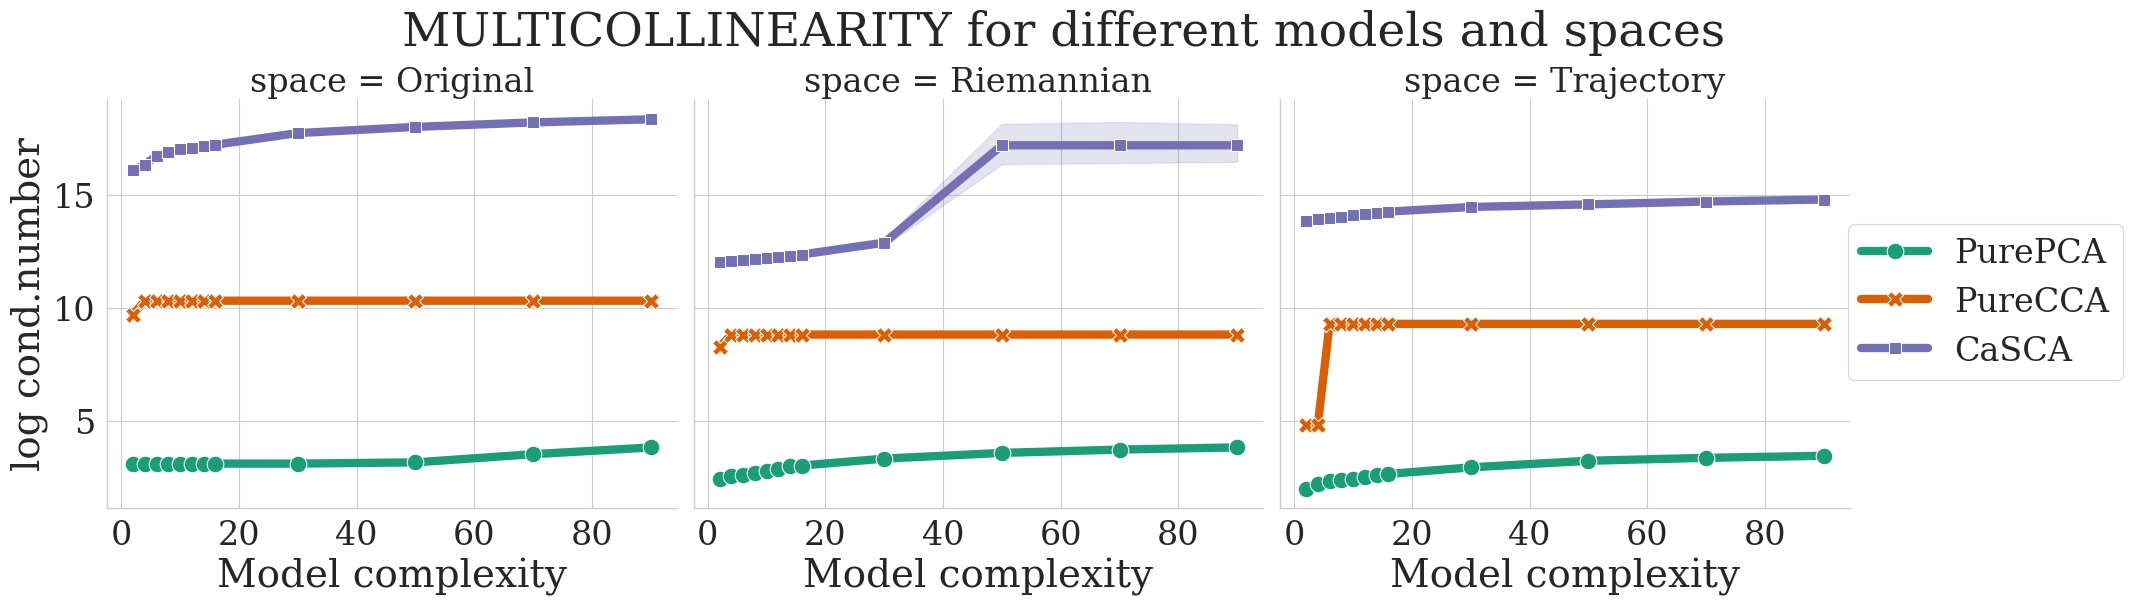

In [52]:
g = sns.FacetGrid(all_combined, col="space", sharey=True, height=6, aspect=1.05)
g.map_dataframe(
    sns.lineplot,
    x="d_hid", y="log_cond_XTX",
    hue="method", style="method",
    markers=True, dashes=False,  # solid lines + markers
    palette="Dark2",
    linewidth=6
)

g.add_legend(frameon=True)
g.fig.suptitle("MULTICOLLINEARITY for different models and spaces", fontsize=34)
g.fig.subplots_adjust(top=0.83)

for ax in g.axes.flat:
    ax.set_xlabel("Model complexity", fontsize=28)
    ax.set_ylabel("log cond.number", fontsize=28)
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    
plt.savefig(os.path.join(FIGURES_DIR, 'other-models-multicollinearity.pdf'))
plt.show()

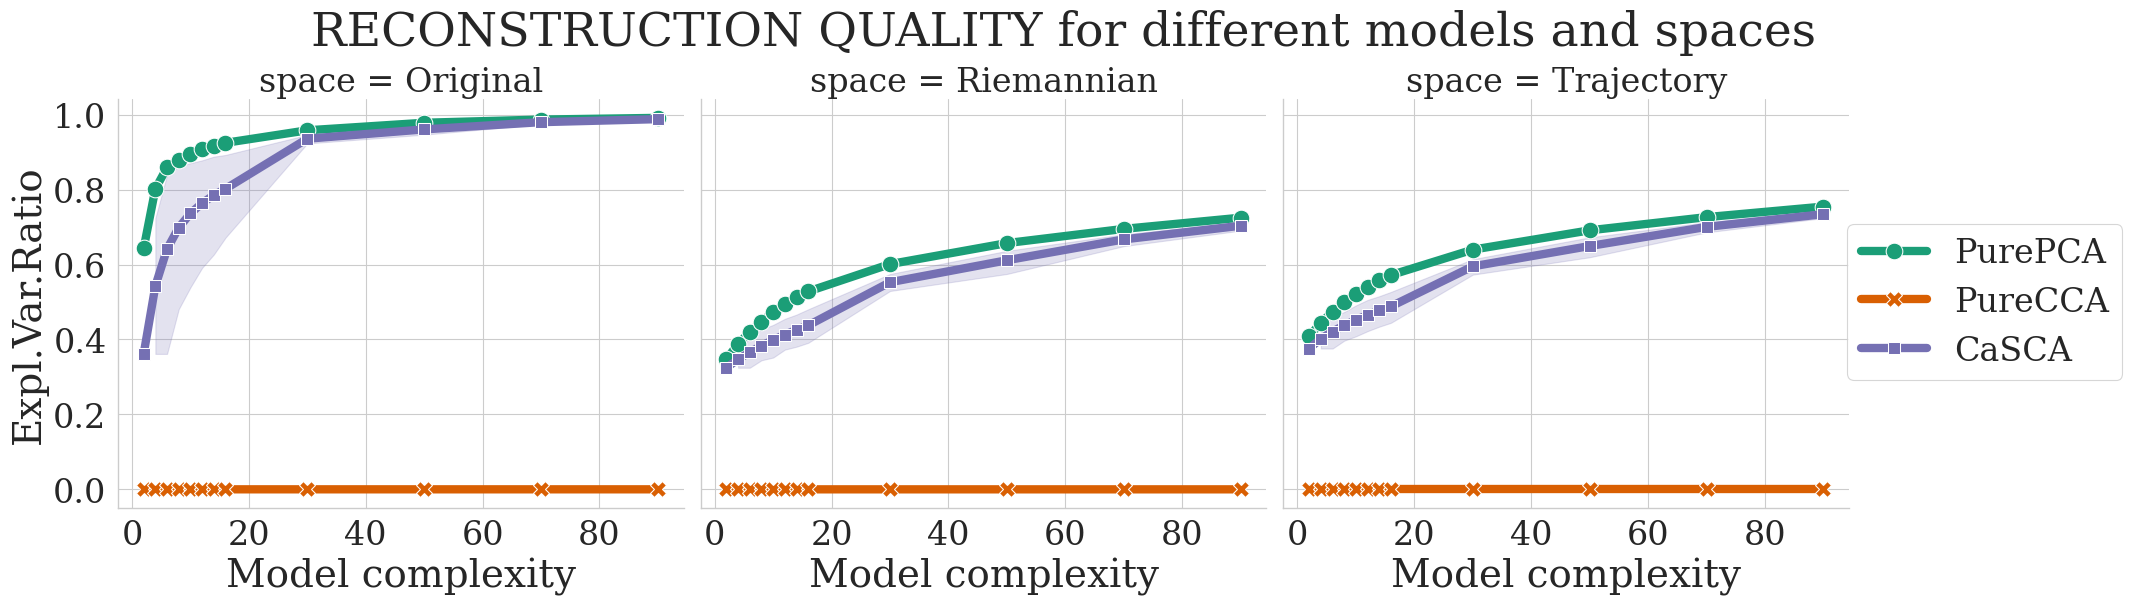

In [53]:
g = sns.FacetGrid(all_combined, col="space", sharey=True, height=6, aspect=1.05)
g.map_dataframe(
    sns.lineplot,
    x="d_hid", y="ExplVar",
    hue="method", style="method",
    markers=True, dashes=False,  # solid lines + markers
    palette="Dark2",
    linewidth=6
)

g.add_legend(frameon=True)
g.fig.suptitle("RECONSTRUCTION QUALITY for different models and spaces", fontsize=34)
g.fig.subplots_adjust(top=0.83)

for ax in g.axes.flat:
    ax.set_xlabel("Model complexity", fontsize=28)
    ax.set_ylabel("Expl.Var.Ratio", fontsize=28)
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    
plt.savefig(os.path.join(FIGURES_DIR, 'other-models-reconstruction.pdf'))
plt.show()

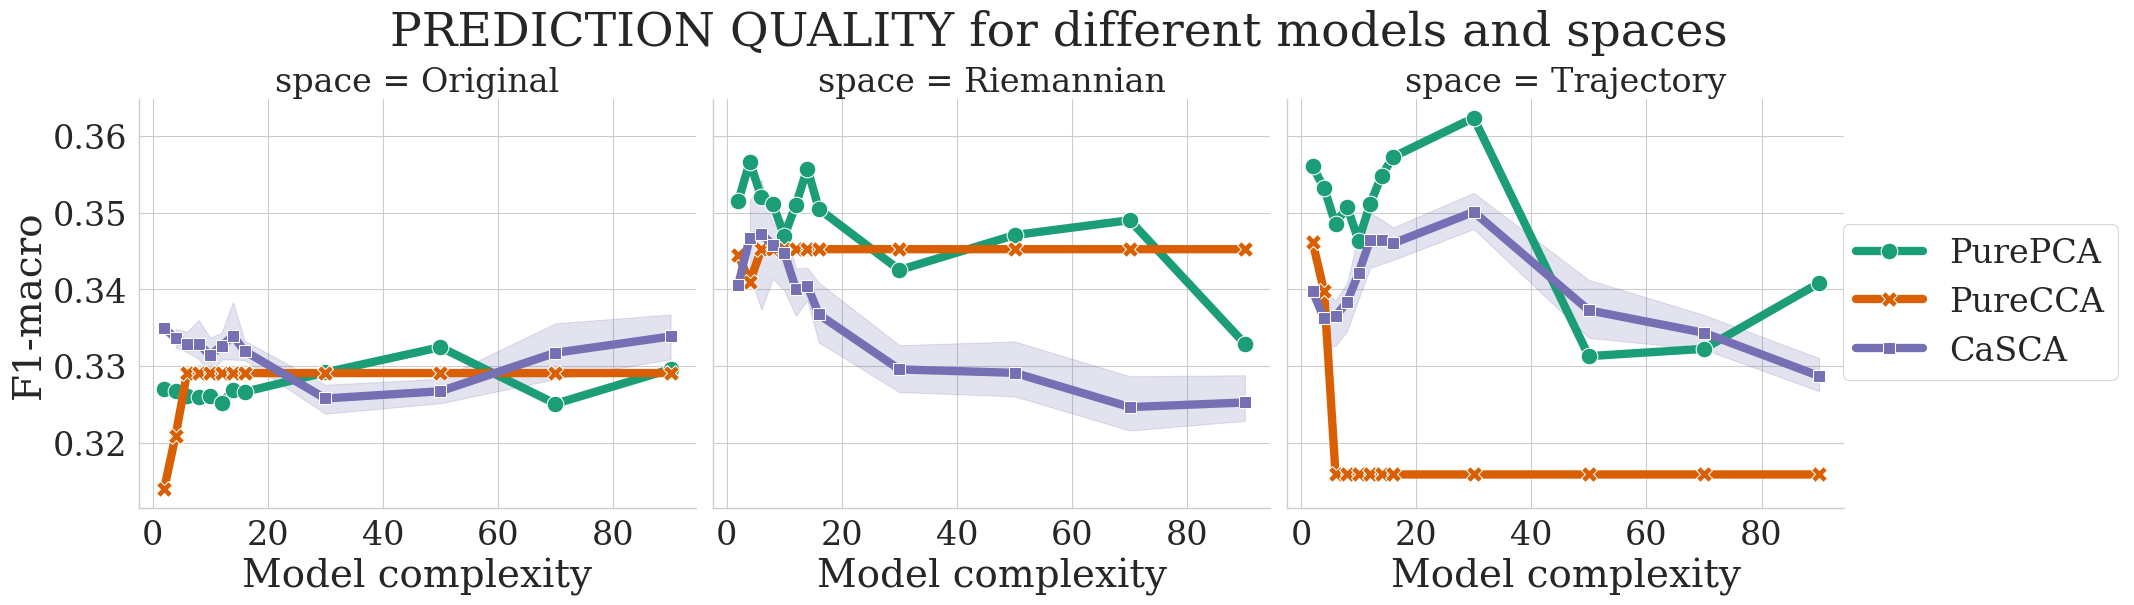

In [54]:
g = sns.FacetGrid(all_combined, col="space", sharey=True, height=6, aspect=1.05)
g.map_dataframe(
    sns.lineplot,
    x="d_hid", y="max_F1m",  # or "max_F1m" if you prefer macro
    hue="method", style="method",
    markers=True, dashes=False,  # solid lines + markers
    palette="Dark2",
    linewidth=6
)

g.add_legend(frameon=True)
g.fig.suptitle("PREDICTION QUALITY for different models and spaces", fontsize=34)
g.fig.subplots_adjust(top=0.83)

for ax in g.axes.flat:
    ax.set_xlabel("Model complexity", fontsize=28)
    ax.set_ylabel("F1-macro", fontsize=28)
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    
plt.savefig(os.path.join(FIGURES_DIR, 'other-models-prediction-f1-macro.pdf'))
plt.show()

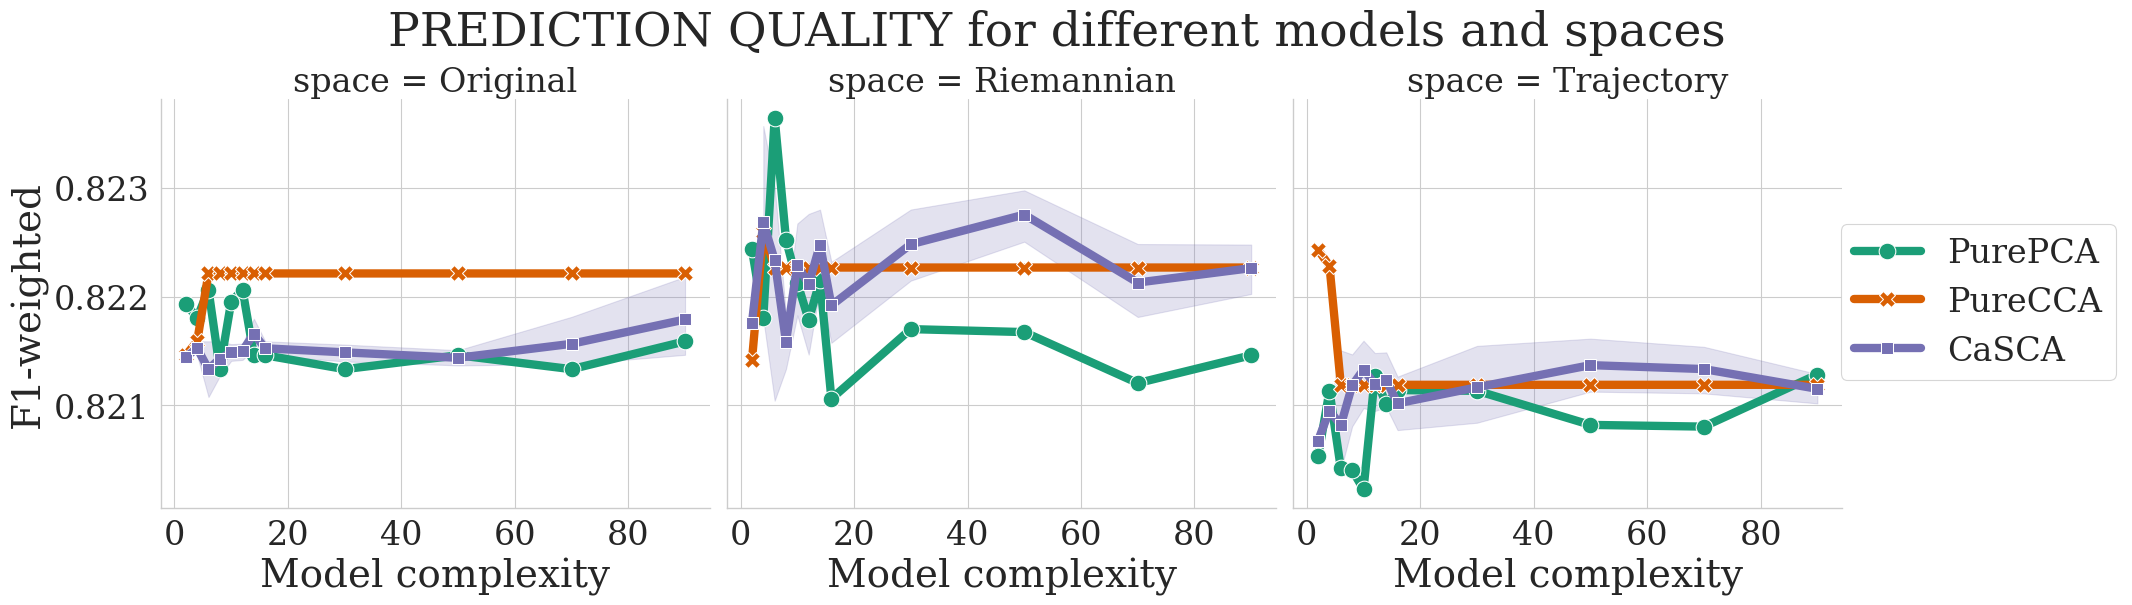

In [56]:
g = sns.FacetGrid(all_combined, col="space", sharey=True, height=6, aspect=1.05)
g.map_dataframe(
    sns.lineplot,
    x="d_hid", y="max_F1w",  # or "max_F1m" if you prefer macro
    hue="method", style="method",
    markers=True, dashes=False,  # solid lines + markers
    palette="Dark2",
    linewidth=6
)

g.add_legend(frameon=True)
g.fig.suptitle("PREDICTION QUALITY for different models and spaces", fontsize=34)
g.fig.subplots_adjust(top=0.83)

for ax in g.axes.flat:
    ax.set_xlabel("Model complexity", fontsize=28)
    ax.set_ylabel("F1-weighted", fontsize=28)
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    
plt.savefig(os.path.join(FIGURES_DIR, 'other-models-prediction-f1-weighted.pdf'))
plt.show()

### $d_c$ - $d_{hid} \;$ tradeoff in CaSCA

#### Original space

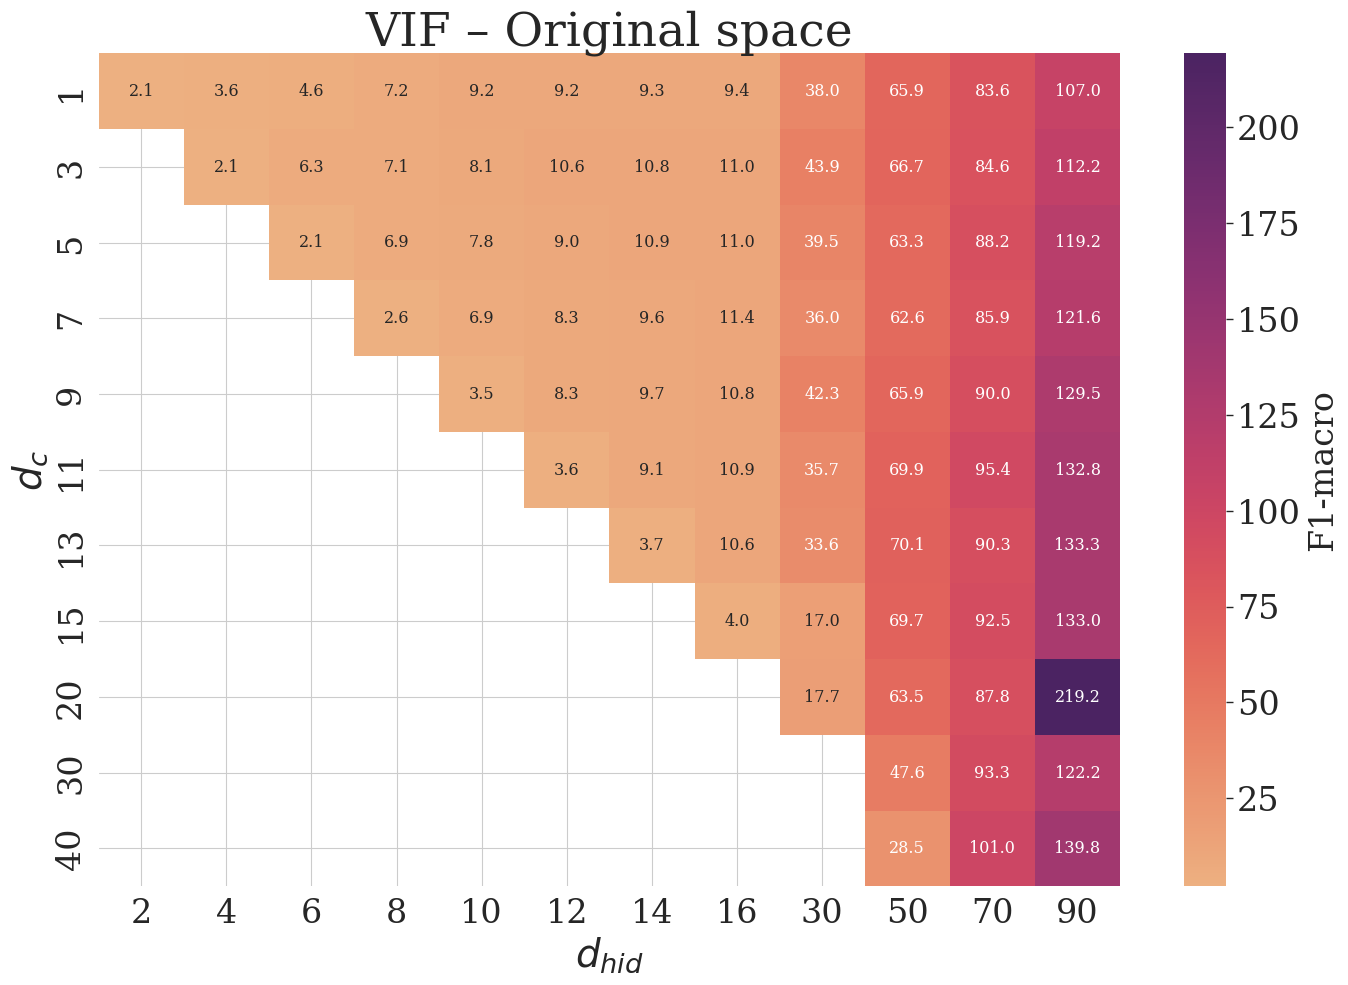

In [43]:
plot_heatmap(original_casca, value='VIF', cmap="flare", fmt=".1f",
             title="VIF – Original space")

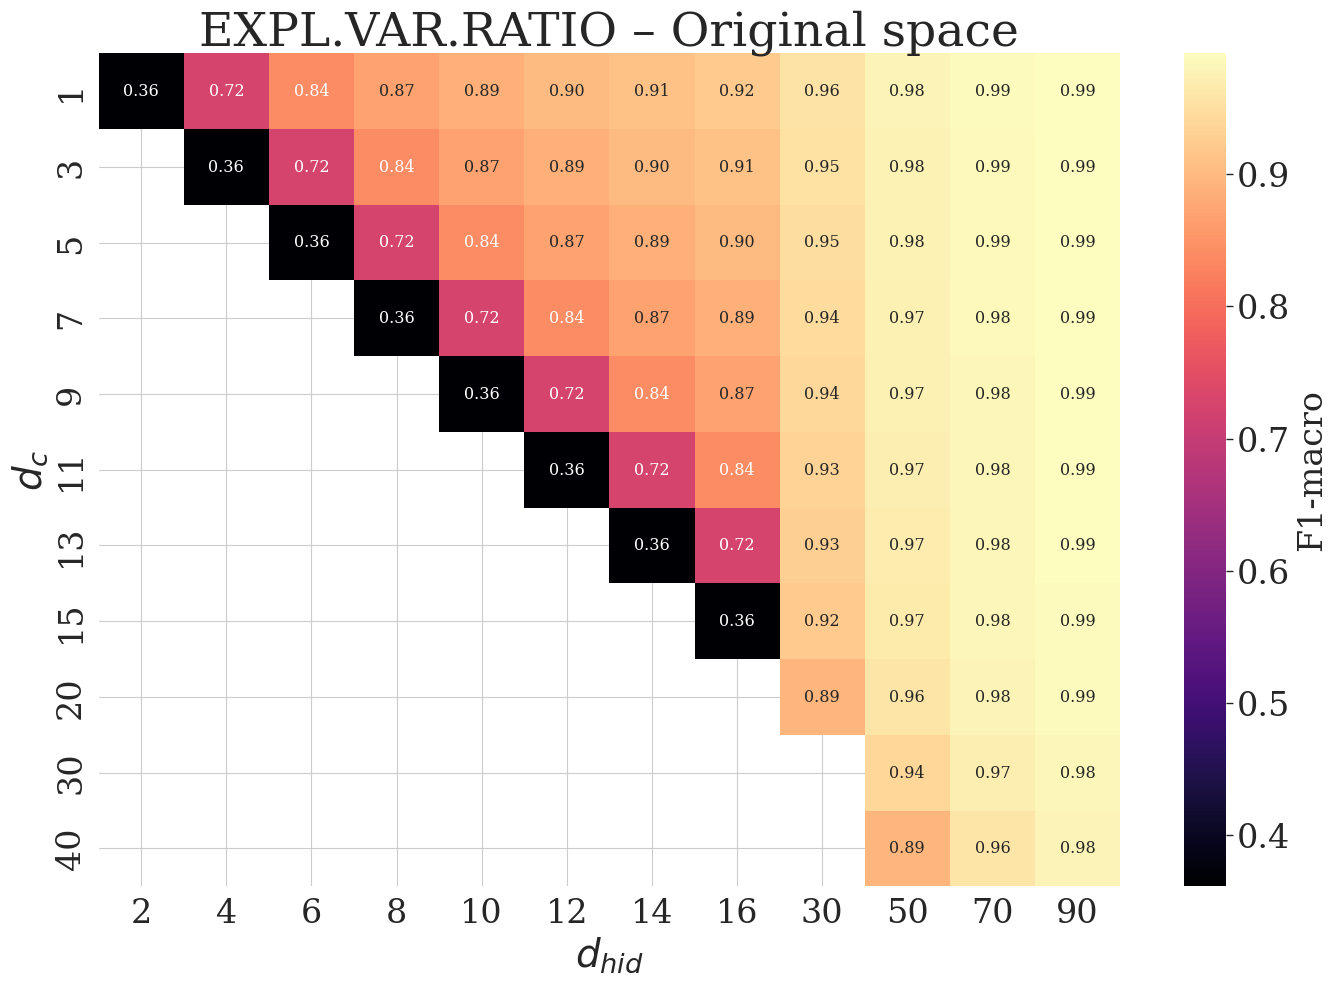

In [44]:
plot_heatmap(original_casca, value='ExplVar', cmap="magma", fmt=".2f",
             title="EXPL.VAR.RATIO – Original space")

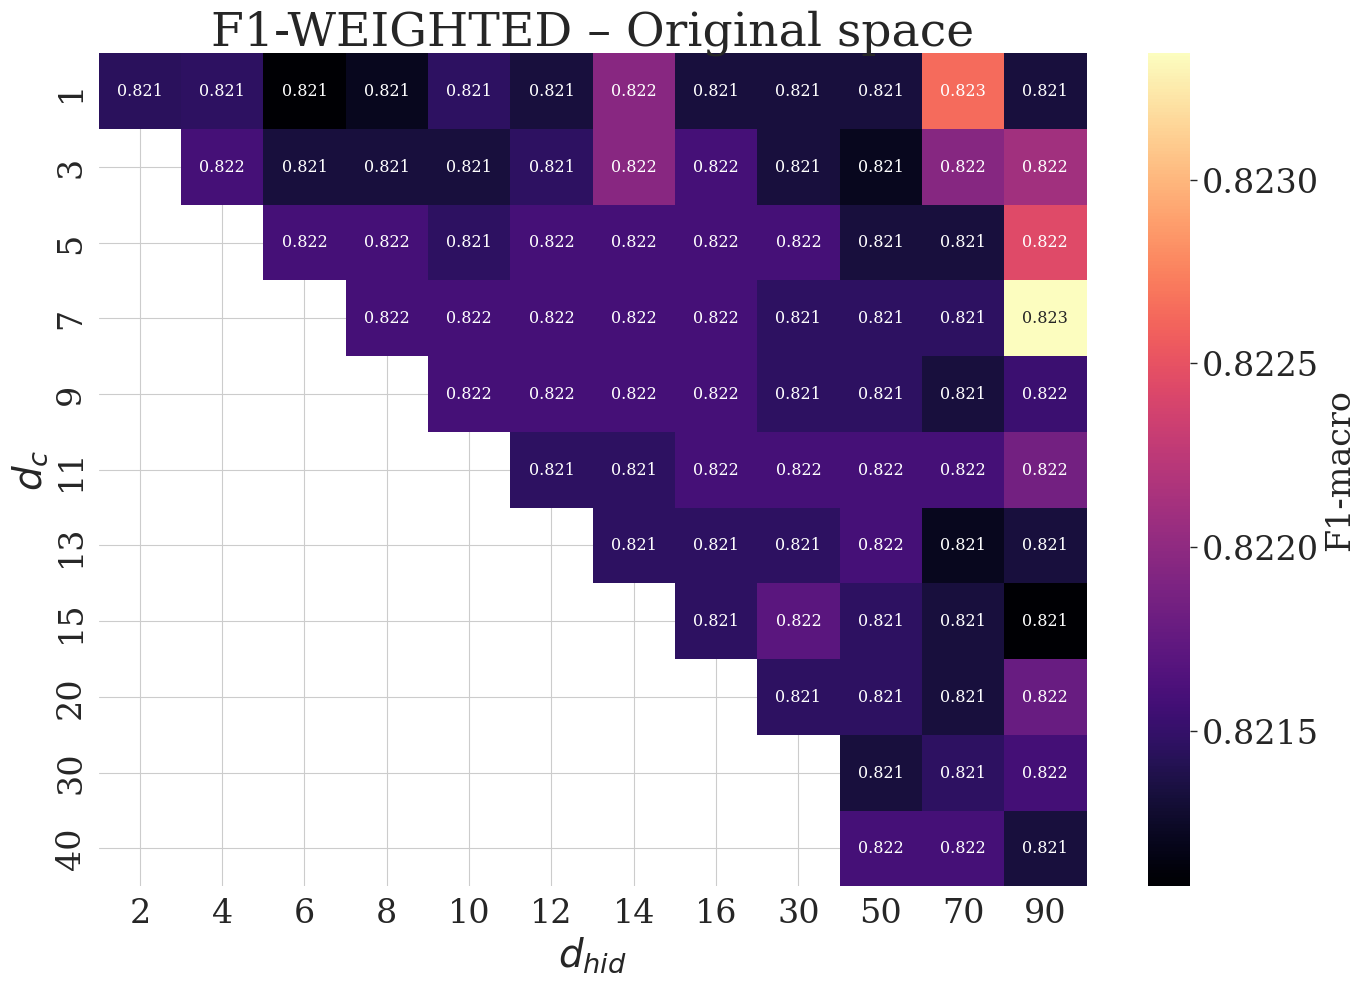

In [45]:
plot_heatmap(original_casca, value='max_F1w', cmap="magma",
             title="F1-WEIGHTED – Original space")

#### Riemannian space

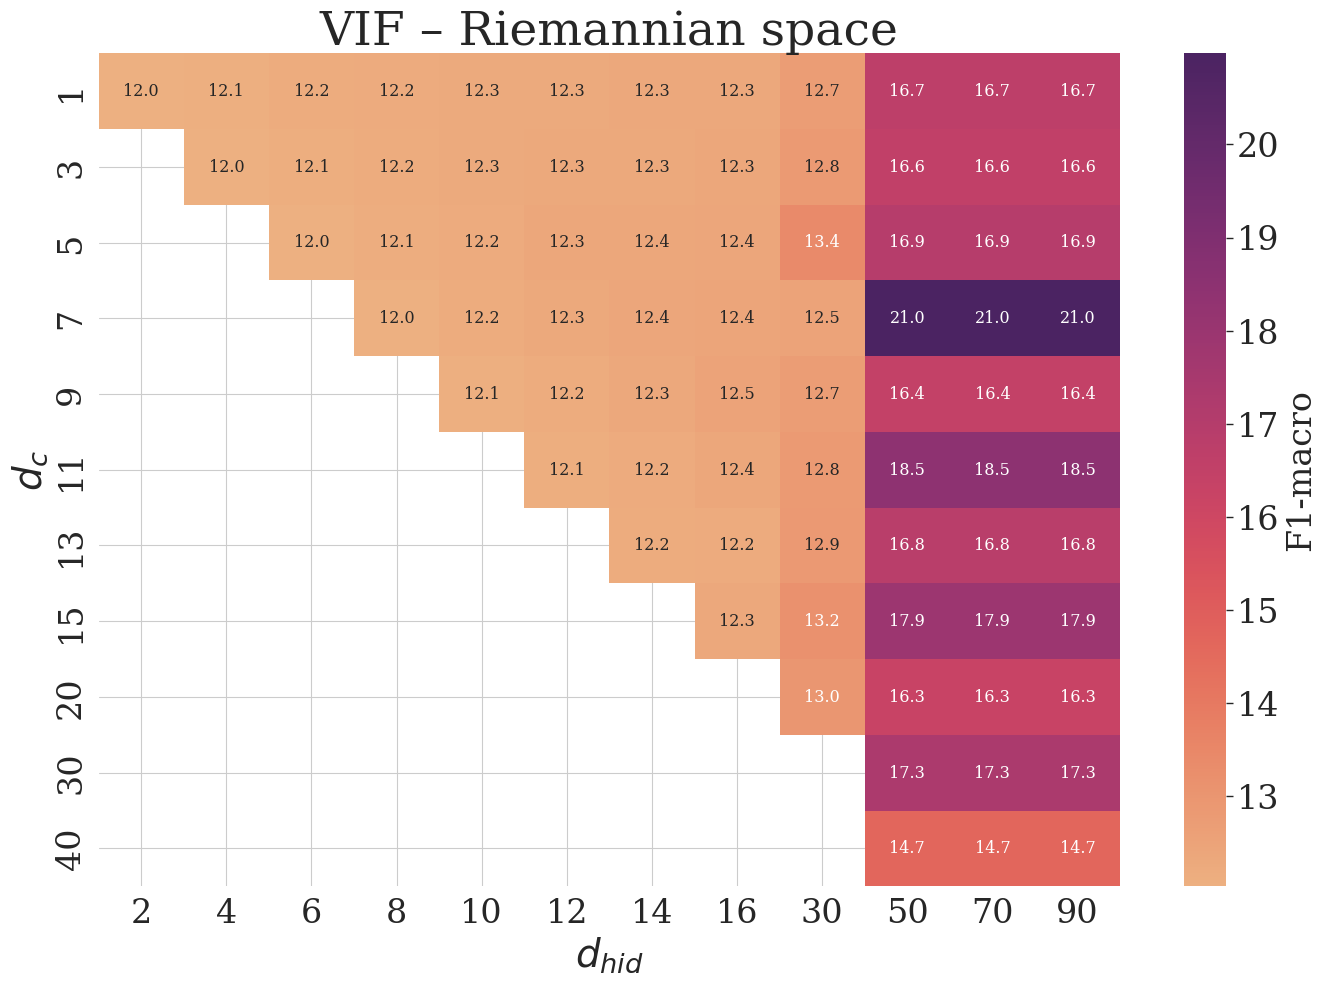

In [46]:
plot_heatmap(riemannian_casca, value='log_cond_XTX', cmap="flare", fmt=".1f",
             title="VIF – Riemannian space")

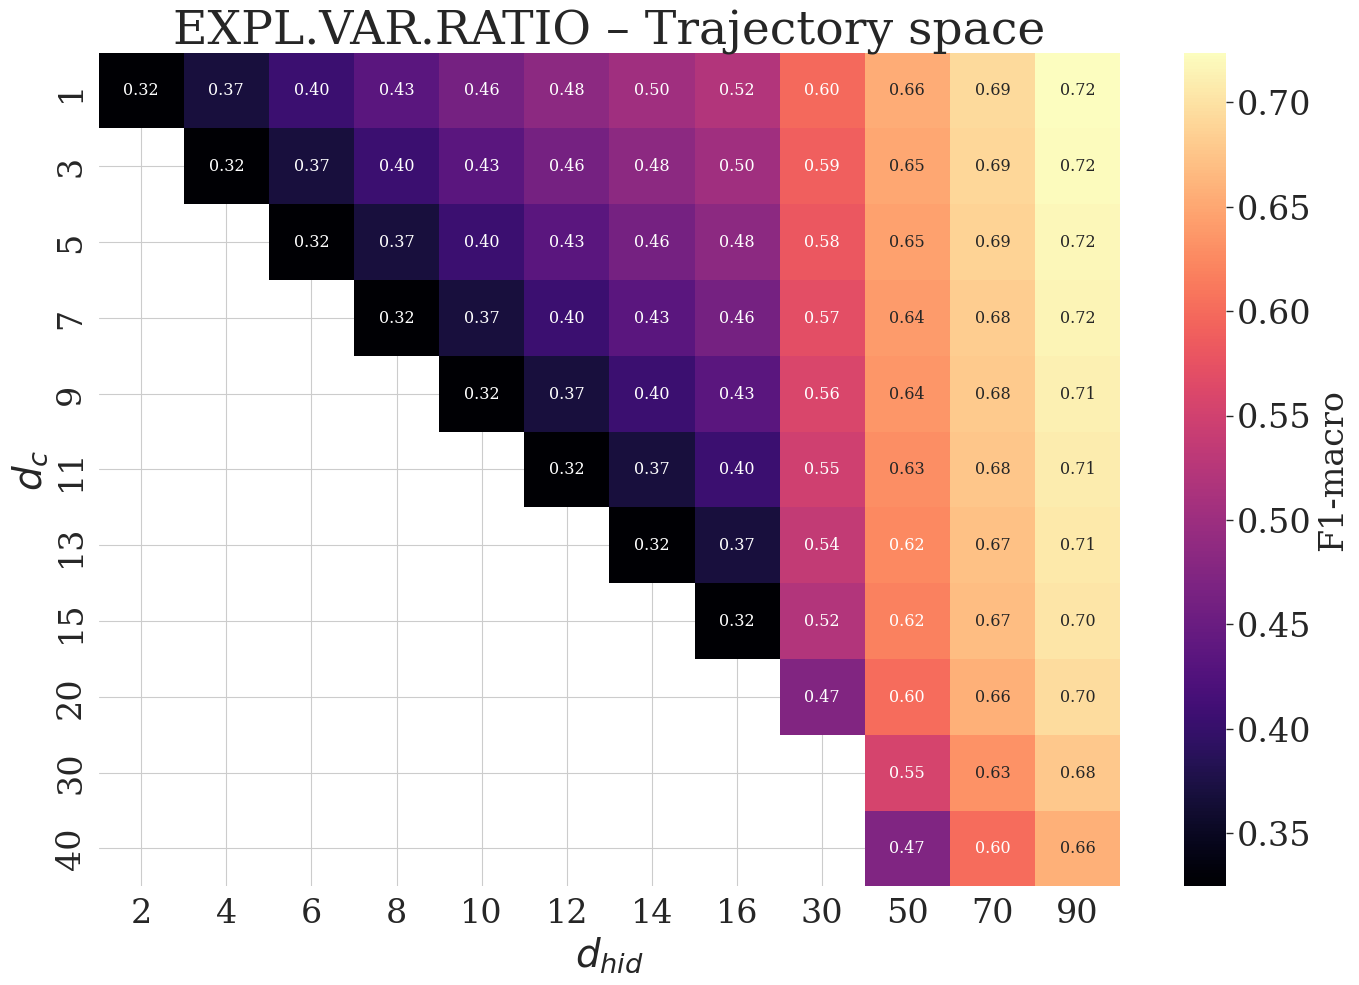

In [47]:
plot_heatmap(riemannian_casca, value='ExplVar', cmap="magma", fmt=".2f",
             title="EXPL.VAR.RATIO – Trajectory space")

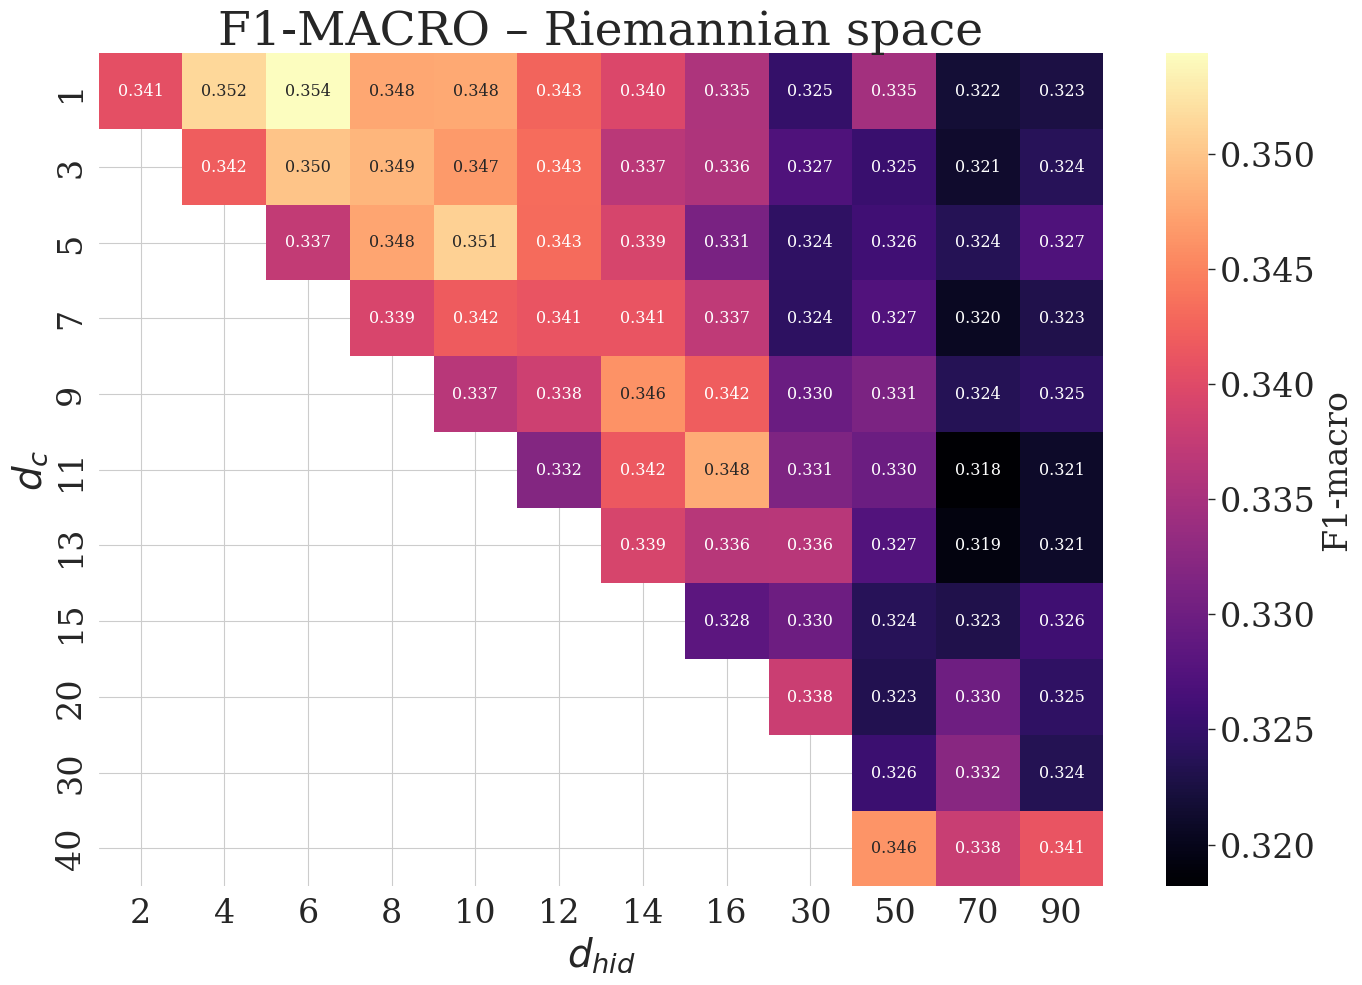

In [48]:
plot_heatmap(riemannian_casca, value='max_F1m', cmap="magma",
             title="F1-MACRO – Riemannian space")

#### Trajectory space

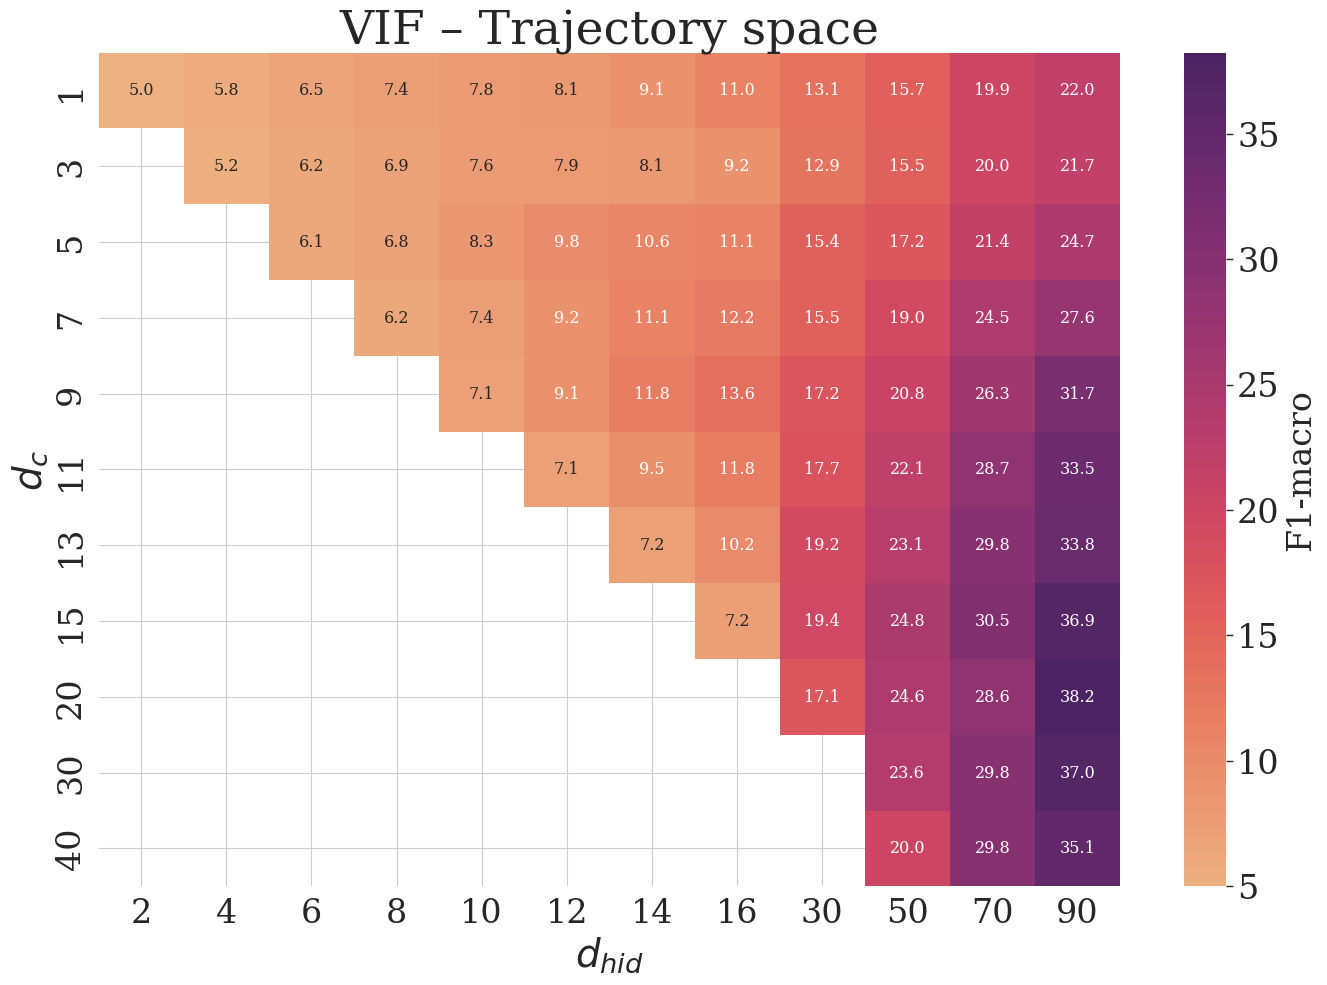

In [49]:
plot_heatmap(trajectory_casca, value='VIF', cmap="flare", fmt=".1f",
             title="VIF – Trajectory space")

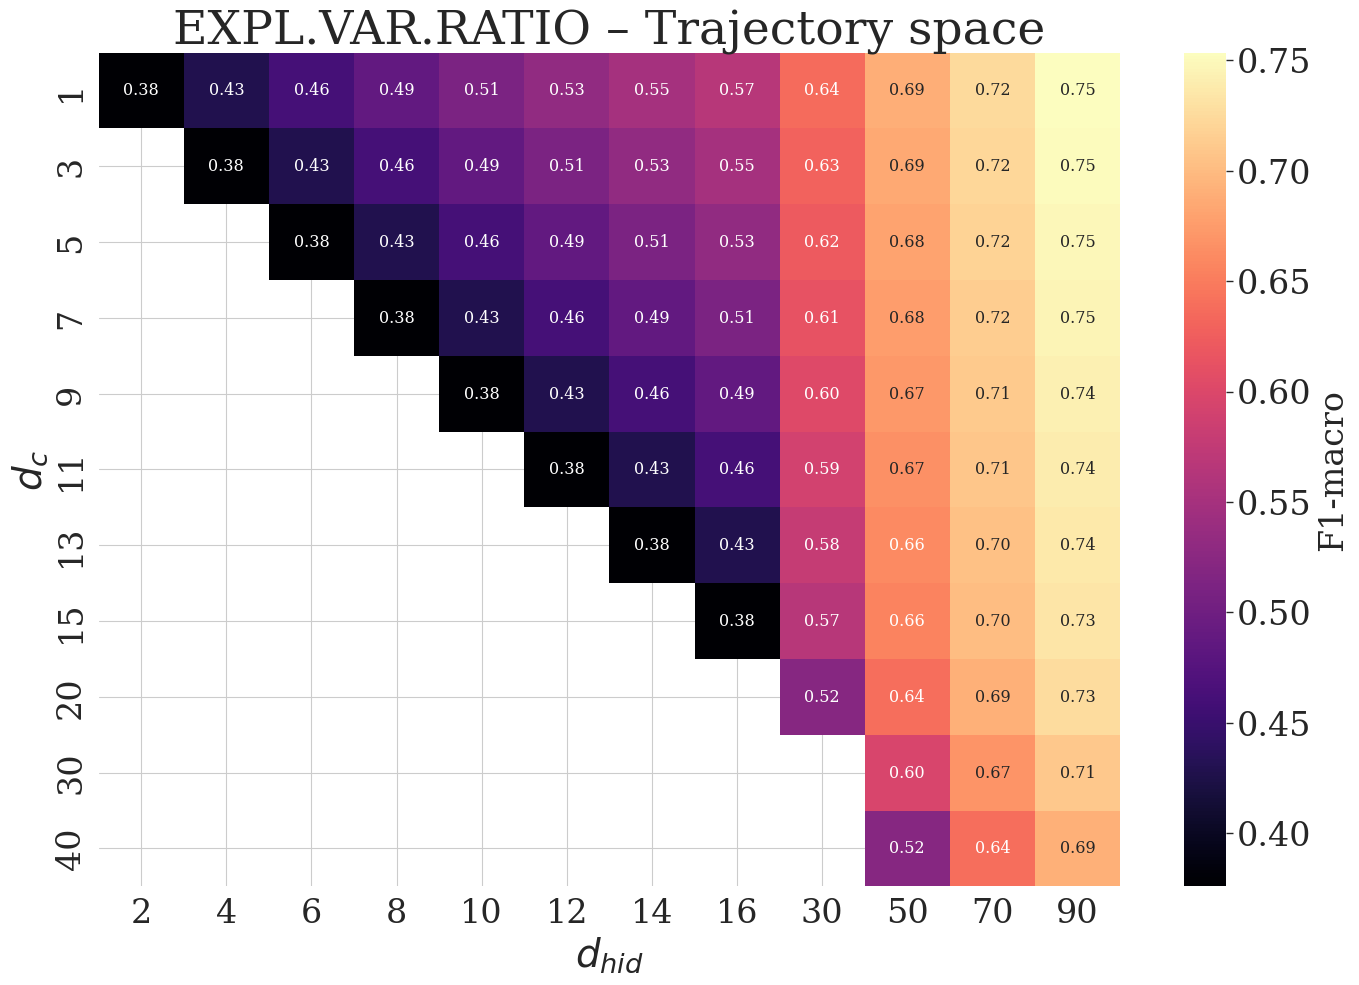

In [50]:
plot_heatmap(trajectory_casca, value='ExplVar', cmap="magma", fmt=".2f",
             title="EXPL.VAR.RATIO – Trajectory space")

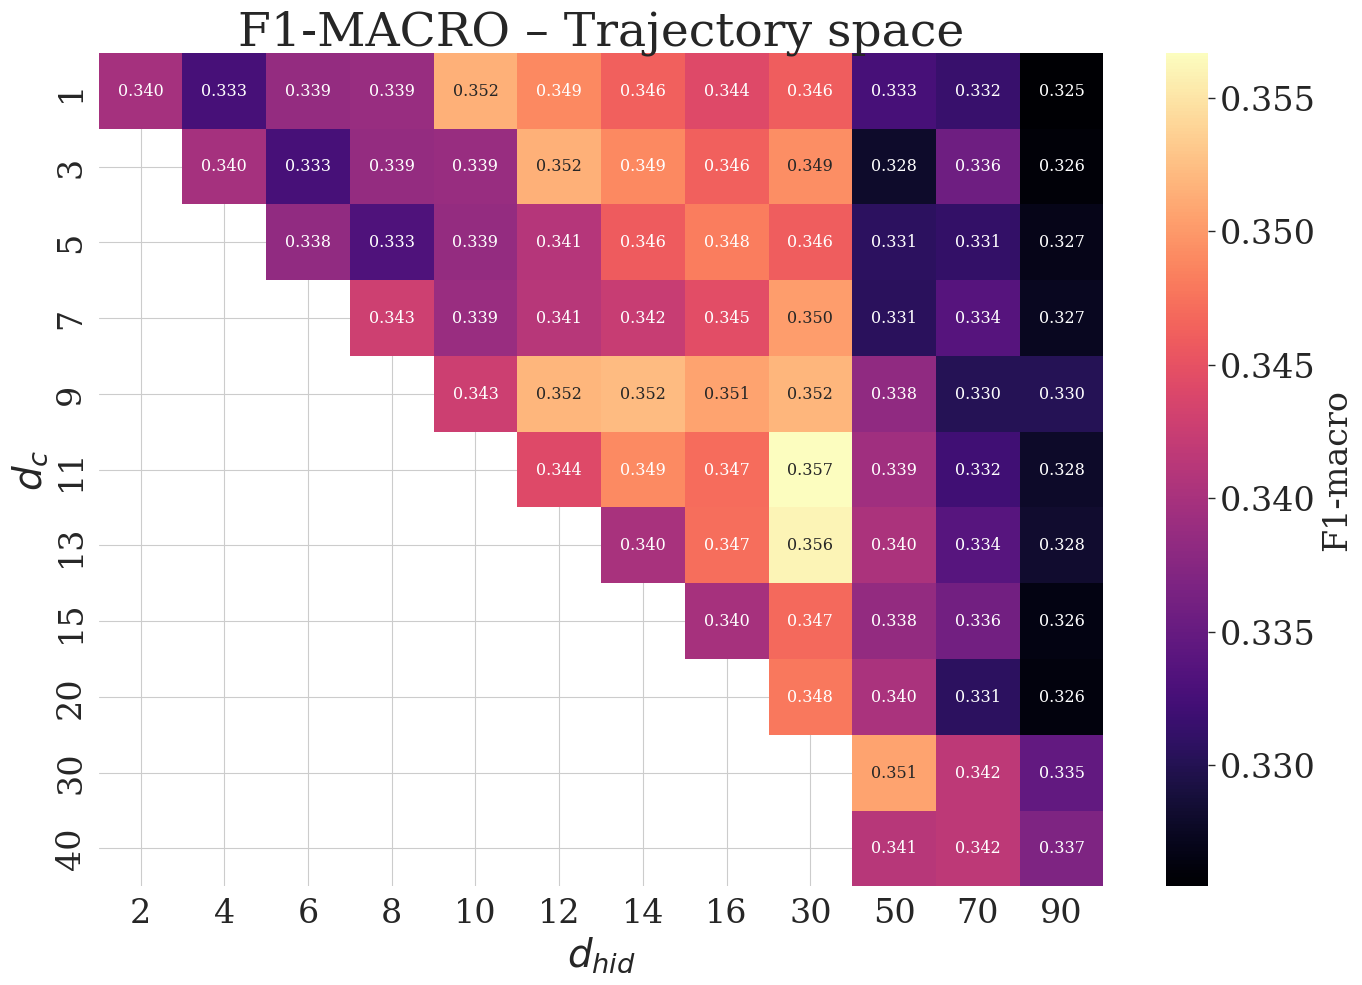

In [51]:
plot_heatmap(trajectory_casca, value='max_F1m', cmap="magma",
             title="F1-MACRO – Trajectory space")